In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy

In [2]:
@dataclass
class ModelResults:
    # predicted values
    y_pred: list = None
    y_pred_bestourmethod: list = None
    y_pred_bestinsidemethod: list = None
    # data related to full set
    fulldescriptors: list = None
    labels: list = None
    top_correlation: list = None
    # data realated to inside and our methods
    inside_methods_rmse: list = None
    bestinsidemethod_rmse: float = 0.0
    bestinsidemethod: str = None
    inside_methods_r2: list = None
    our_methods_rmse: dict = None
    bestourmethod_rmse: float = 0.0
    bestourmethod: str = None
    our_methods_r2: dict = None
    our_methods_name : list = None

def read_and_init (inrootdir, supersetnames, howmanydifs, methods, \
                   DEBUG=False):
    
    allvalues_perset = {}
    fullsetnames = []
    models_results = {}

    toberemoved = {}
    for super_setname in supersetnames:
        toberemoved[super_setname] = []
        allvalues_perset[super_setname] = []
        fullsetnames.append(super_setname)
        for i, setname in enumerate(supersetnames[super_setname]):
              print("Reading dataset: ", setname)
              rootdir = inrootdir + super_setname + "/" +setname
              labelsfilename = inrootdir + setname +"_labels.txt"
        
              values =\
                    commonutils.read_dataset(rootdir, labelsfilename, \
                                             howmanydifs, methods, \
                                             debug=DEBUG)
              
              if (values is None) or (len(values) <= 2):
                    print(setname + " No data found for this dataset")
                    print("")
                    toberemoved[super_setname].append(i)
              else:
                    fullsetname = super_setname+"_"+setname
                    fullsetnames.append(fullsetname)
                    allvalues_perset[fullsetname] = values  
                    print("Number of samples: ", len(allvalues_perset[fullsetname]))
                    print("Number of basic descriptors: ", len(allvalues_perset[fullsetname]))
              
                    allvalues_perset[super_setname] += allvalues_perset[fullsetname]
                    print("")

    for super_setname in toberemoved:
        for i in sorted(toberemoved[super_setname], reverse=True):
          del supersetnames[super_setname][i]
    
    allvalues_perset["Full"] = []
    for super_setname in supersetnames:
          allvalues_perset["Full"] += allvalues_perset[super_setname]  
    fullsetnames.append("Full")

    for setname in fullsetnames:
        models_results[setname] = ModelResults()

    return allvalues_perset, fullsetnames, models_results


In [3]:
warnings.simplefilter("ignore")
CORRCUT = 0.98

supersetnames = {"BARRIER_HEIGHTS" : \
                       ["BH76","BHDIV10","BHPERI",\
                        "BHROT27","INV24","PX13","WCPT18"] \
                    ,"INTRAMOLECULAR_INTERACTIONS" : \
                       ["ACONF","ICONF","IDISP","MCONF",\
                        "PCONF21","SCONF","UPU23"] , \
                    "SMALL_MOLECULES" :\
                        ["AL2X6","ALK8","ALKBDE10","BH76",\
                         "DC13","DIPCS10","FH51","G21EA",\
                         "G21IP","G2RC","HEAVYSB11","NBPRC",\
                         "PA26","RC21","SIE4x4","TAUT15",\
                         "W4-11","YBDE18"], \
                    "INTERMOLECULAR_INTERACTIONS" :\
                       ["ADIM6","AHB21","CARBHB12",\
                        "CHB6","HAL59","HEAVY28","IL16",\
                        "PNICO23","RG18","S22","S66","WATER27"] , \
                    "LARGE_SYSTEMS" :\
                        ["BSR36","C60ISO","CDIE20","DARC",\
                         "ISO34","ISOL24","MB16-43","PArel",\
                            "RSE43"]}    
howmanydifs = 3
methods = {"PBE" : ["Nuclear Repulsion  :", \
                        "One Electron Energy:", \
                        "Two Electron Energy:", \
                        "Potential Energy   :", \
                        "Kinetic Energy     :", \
                        "E(X)               :"  , \
                        "E(C)               :"  , \
                        "Dispersion correction", \
                        "FINAL SINGLE POINT ENERGY"], 
                "PBE0" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"] ,
                "ZORA" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"],
                "TPSSh" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"]
                }
# read all the data and initialize the data structures
rootdir = "../datasets/AllData/"   
allvalues_perset, fullsetnames, models_results = \
        read_and_init (rootdir, supersetnames, howmanydifs, methods, \
                       DEBUG=False)

Reading dataset:  BH76
BH76 No data found for this dataset

Reading dataset:  BHDIV10
Number of samples:  10
Number of basic descriptors:  10

Reading dataset:  BHPERI
Number of samples:  26
Number of basic descriptors:  26

Reading dataset:  BHROT27
Number of samples:  27
Number of basic descriptors:  27

Reading dataset:  INV24
Number of samples:  24
Number of basic descriptors:  24

Reading dataset:  PX13
Number of samples:  13
Number of basic descriptors:  13

Reading dataset:  WCPT18
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  ACONF
Number of samples:  15
Number of basic descriptors:  15

Reading dataset:  ICONF
Number of samples:  17
Number of basic descriptors:  17

Reading dataset:  IDISP
Number of samples:  6
Number of basic descriptors:  6

Reading dataset:  MCONF
Number of samples:  51
Number of basic descriptors:  51

Reading dataset:  PCONF21
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  SCONF
Number of samples:  

In [4]:
allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)
for setname in fullsetnames:
    models_results[setname].inside_methods_rmse = []
    models_results[setname].inside_methods_r2 = []
    models_results[setname].our_methods_rmse = {}
    models_results[setname].our_methods_r2 = {}
    
    models_results[setname].bestinsidemethod_rmse = float("inf")
    models_results[setname].bestinsidemethod = ""
    models_results[setname].bestourmethod_rmse = float("inf")
    models_results[setname].bestourmethod = ""
    models_results[setname].our_methods_name = []

    for methodid in range(howmanydifs):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])
            labels.append(val["label"])
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)
        models_results[setname].inside_methods_rmse.append(rmse)
        models_results[setname].inside_methods_r2.append(r2)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod = str(methodid)
            models_results[setname].y_pred_bestinsidemethod = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])
            labels.append(val["label"])
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)

        models_results[setname].our_methods_rmse[method] = rmse
        models_results[setname].our_methods_r2[method] = r2
        models_results[setname].our_methods_name.append(method)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod = method
            models_results[setname].y_pred_bestourmethod = y_pred

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
      "Best inside method", " , ", \
      "RMSE", " , ", \
      "Best our method", " , ", \
      "RMSE")
for setname in fullsetnames:
    print("%40s"%setname, " , ", \
        models_results[setname].bestinsidemethod , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%5s"%models_results[setname].bestourmethod , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse)


Results for inside and our methods
                                 Dataset  ,  Best inside method  ,  RMSE  ,  Best our method  ,  RMSE
                         BARRIER_HEIGHTS  ,  0  ,    6.410  ,   PBE0  ,   21.488
                 BARRIER_HEIGHTS_BHDIV10  ,  0  ,    9.191  ,   ZORA  ,   14.651
                  BARRIER_HEIGHTS_BHPERI  ,  0  ,    4.407  ,   PBE0  ,   17.811
                 BARRIER_HEIGHTS_BHROT27  ,  1  ,    0.611  ,  TPSSh  ,    2.686
                   BARRIER_HEIGHTS_INV24  ,  2  ,    2.658  ,   PBE0  ,    5.711
                    BARRIER_HEIGHTS_PX13  ,  0  ,   11.730  ,   PBE0  ,   49.956
                  BARRIER_HEIGHTS_WCPT18  ,  0  ,    8.999  ,   PBE0  ,   24.302
             INTRAMOLECULAR_INTERACTIONS  ,  2  ,    1.137  ,   PBE0  ,    5.268
       INTRAMOLECULAR_INTERACTIONS_ACONF  ,  2  ,    0.090  ,   PBE0  ,    1.250
       INTRAMOLECULAR_INTERACTIONS_ICONF  ,  2  ,    0.450  ,    PBE  ,    1.496
       INTRAMOLECULAR_INTERACTIONS_IDISP  ,  2  ,    

In [5]:
setname = "Full"
models_results[setname].fulldescriptors = []
models_results[setname].labels = []
for idx, val in enumerate(allvalues_perset[setname]):
    models_results[setname].fulldescriptors.append({})
    for method in methods:
        models_results[setname].fulldescriptors[idx].update(val[method+"_energydiff"])

    models_results[setname].labels.append(val["label"])

X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

corr = df.corr().abs()
top_correlation = {}
for k in corr.columns:
    top_correlation[k] = []
    print(k, " ")
    for idx, v in enumerate(corr[k]):
        if v > CORRCUT and corr.index[idx] != k:
            top_correlation[k].append((corr.index[idx], v))
            print(" %40s %4.2f"%(corr.index[idx], v))

PBE_Dispersion_correction  
               PBE0_Dispersion_correction 1.00
               ZORA_Dispersion_correction 1.00
              TPSSh_Dispersion_correction 1.00
PBE_Potential_Energy  
                    PBE0_Potential_Energy 0.99
                    ZORA_Potential_Energy 0.99
                   TPSSh_Potential_Energy 0.99
PBE_E(C)  
                                PBE0_E(C) 1.00
                                ZORA_E(C) 1.00
                               TPSSh_E(C) 1.00
PBE_E(X)  
                                PBE0_E(X) 1.00
                                ZORA_E(X) 1.00
                               TPSSh_E(X) 1.00
PBE_Two_Electron_Energy  
                    PBE_Nuclear_Repulsion 1.00
                  PBE_One_Electron_Energy 1.00
                   PBE0_Nuclear_Repulsion 1.00
                 PBE0_Two_Electron_Energy 1.00
                 PBE0_One_Electron_Energy 1.00
                   ZORA_Nuclear_Repulsion 1.00
                 ZORA_One_Electron_Energy 1.00
        

In [6]:
featurestorms = set()
for tc in top_correlation:
    if tc not in featurestorms:
        for correlated in top_correlation[tc]:
            featurestorms.add(correlated[0])

print ("Features that are correlated with others and to remove")  
for idx, k in enumerate(featurestorms):
    print(idx+1 , " ", k)

Features that are correlated with others and to remove
1   TPSSh_Dispersion_correction
2   TPSSh_FINAL_SINGLE_POINT_ENERGY
3   ZORA_Dispersion_correction
4   PBE0_Kinetic_Energy
5   TPSSh_Kinetic_Energy
6   ZORA_E(X)
7   ZORA_FINAL_SINGLE_POINT_ENERGY
8   PBE0_Dispersion_correction
9   ZORA_Nuclear_Repulsion
10   PBE0_E(C)
11   TPSSh_Potential_Energy
12   ZORA_One_Electron_Energy
13   ZORA_Potential_Energy
14   PBE0_E(X)
15   TPSSh_Two_Electron_Energy
16   TPSSh_Nuclear_Repulsion
17   TPSSh_E(X)
18   ZORA_Kinetic_Energy
19   ZORA_E(C)
20   PBE0_Two_Electron_Energy
21   PBE0_FINAL_SINGLE_POINT_ENERGY
22   PBE0_Potential_Energy
23   ZORA_Two_Electron_Energy
24   TPSSh_E(C)
25   PBE0_One_Electron_Energy
26   PBE0_Nuclear_Repulsion
27   TPSSh_One_Electron_Energy
28   PBE_Nuclear_Repulsion
29   PBE_One_Electron_Energy


In [7]:
print ("Features TO USE")
idx = 1
for f in allfeatures:
    if f not in featurestorms:
        print(idx, f) 
        idx += 1 

Features TO USE
1 PBE_Dispersion_correction
2 PBE_Two_Electron_Energy
3 PBE_FINAL_SINGLE_POINT_ENERGY
4 PBE_Potential_Energy
5 PBE_E(C)
6 PBE_E(X)
7 PBE_Kinetic_Energy


In [8]:
featurestorm = list(featurestorms)

for setname in fullsetnames:
    commonutils.remove_features_fromset(allvalues_perset[setname], \
                                            list(featurestorm), \
                                            methods)

for setname in fullsetnames:
    models_results[setname].fulldescriptors = []
    models_results[setname].labels = []
    for idx, val in enumerate(allvalues_perset[setname]):
        models_results[setname].fulldescriptors.append({})
        for method in methods:
            if method+"_energydiff" in val:
                models_results[setname].fulldescriptors[idx].update(\
                    val[method+"_energydiff"])

        models_results[setname].labels.append(val["label"])

setname = "Full"
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

Correlation matrix


<AxesSubplot:>

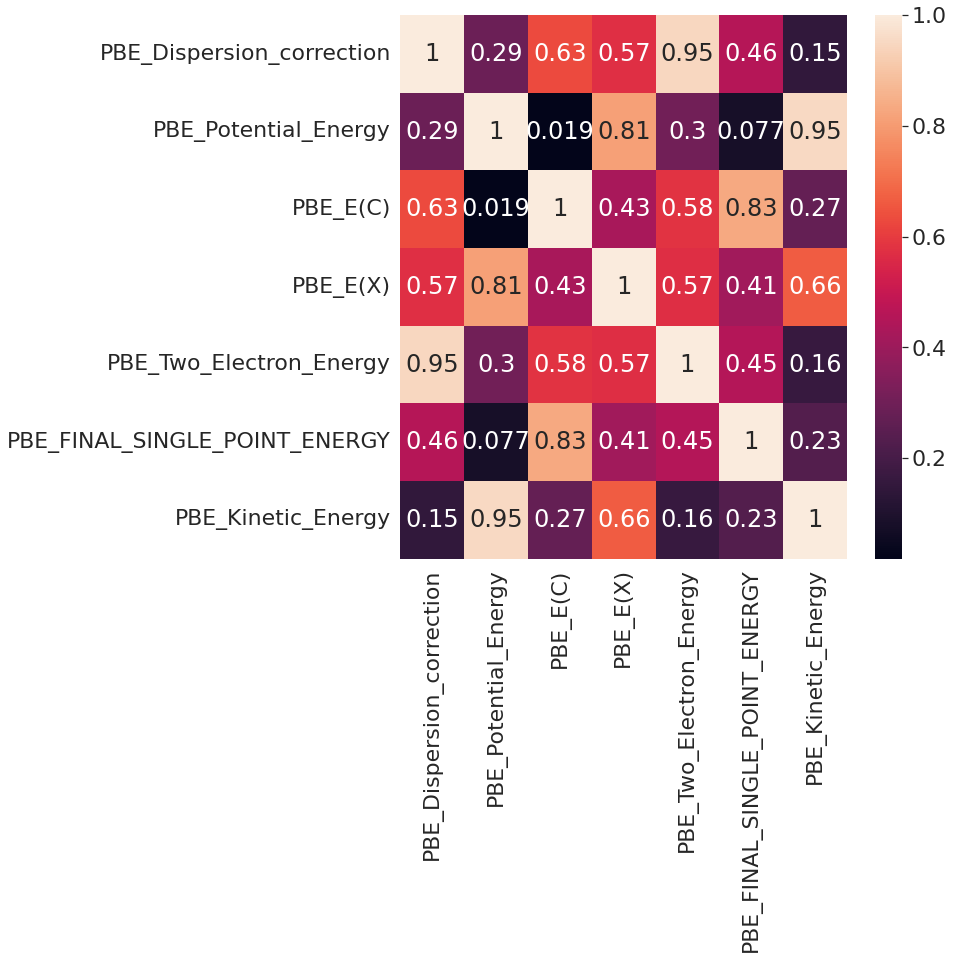

In [9]:
import seaborn as sns
%matplotlib inline
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 10,10
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)

In [10]:
# search for the best model a simple grid search
nepochs = [50, 100]
batch_sizes = [4, 8, 16, 32]
#modelshapes = [[4, 4], [8, 8], [16, 16], \
#                [32, 32], [64, 64], [128, 128], \
#                [4, 4, 4], [8, 8, 8], [16, 16, 16], \
#                [32, 32, 32], [64, 64, 64], \
#                [128, 128, 128], [4, 4, 4, 4], \
#                [8, 8, 8, 8], [16, 16, 16, 16], \
#                [32, 32, 32, 32], [64, 64, 64, 64], \
#                [128, 128, 128, 128]]
modelshapes = [[4, 4, 4], [8, 8, 8], [16, 16, 16], \
                [32, 32, 32], [64, 64, 64], \
                [128, 128, 128], [4, 4, 4, 4], \
                [8, 8, 8, 8], [16, 16, 16, 16], \
                [32, 32, 32, 32], [64, 64, 64, 64], \
                [128, 128, 128, 128], [4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8], [16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32], [64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128], [4, 4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8, 8], [16, 16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32, 32], [64, 64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128, 128]]
setname = "Full"
X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
scalerx = preprocessing.StandardScaler().fit(X)
X_s = scalerx.transform(X) 
scalery = preprocessing.StandardScaler().fit(Y.reshape(-1, 1))
Y_s = scalery.transform(Y.reshape(-1, 1))
modelminrmse, modelsmaxr2 = \
        models.nn_model(0.2, X_s, Y_s, \
                    nepochs, modelshapes, batch_sizes, inputshape=-1,\
                    search=True)
    
print("Best NN model for set: ", setname, file=sys.stderr)
print("  RMSE: ", modelminrmse, file=sys.stderr)
print("    R2: ", modelsmaxr2, file=sys.stderr)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


Best NN model for set:  Full
  RMSE:  ([8, 8, 8], 50, 4)
    R2:  ([8, 8, 8], 50, 4)


In [11]:
import importlib
importlib.reload(models)

#build the final model and print the results
results = models.nn_model(0.2, X_s, Y_s, \
                    [modelminrmse[1]], \
                    [modelminrmse[0]], \
                    [modelminrmse[2]], \
                    inputshape=-1,\
                    search=False)

38/38 [==============================] - 0s 307us/step


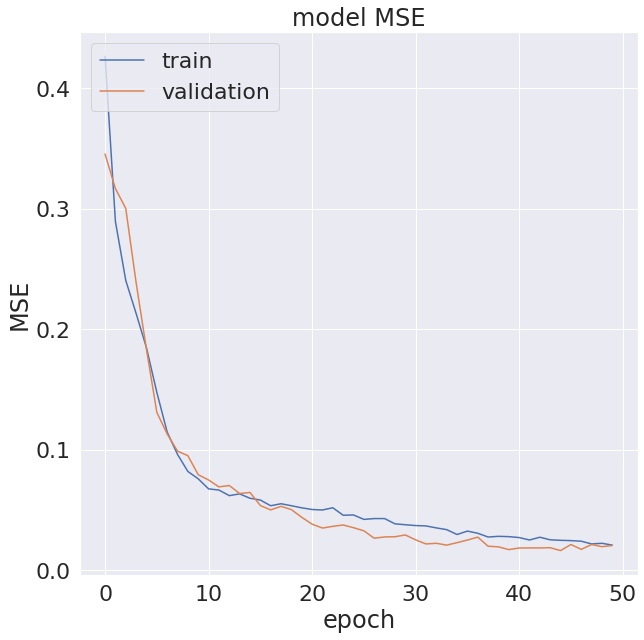

In [12]:
# summarize history for accuracy
history = results['history']
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
# summarize results
print("RMSE Train     : %5.2f"%results['rmse_train'])
print("RMSE Validation: %5.2f"%results['rmse_valid'])
print("RMSE Test      : %5.2f"%results['rmse_test'])
print("RMSE Full      : %5.2f"%results['rmse_full'])
print("R2 Train       : %5.2f"%results['r2_train'])
print("R2 Validation  : %5.2f"%results['r2_valid'])
print("R2 Test        : %5.2f"%results['r2_test'])
print("R2 Full        : %5.2f"%results['r2_full'])

RMSE Train     :  0.14
RMSE Validation:  0.14
RMSE Test      :  0.14
RMSE Full      :  0.14
R2 Train       :  0.98
R2 Validation  :  0.97
R2 Test        :  0.98
R2 Full        :  0.98


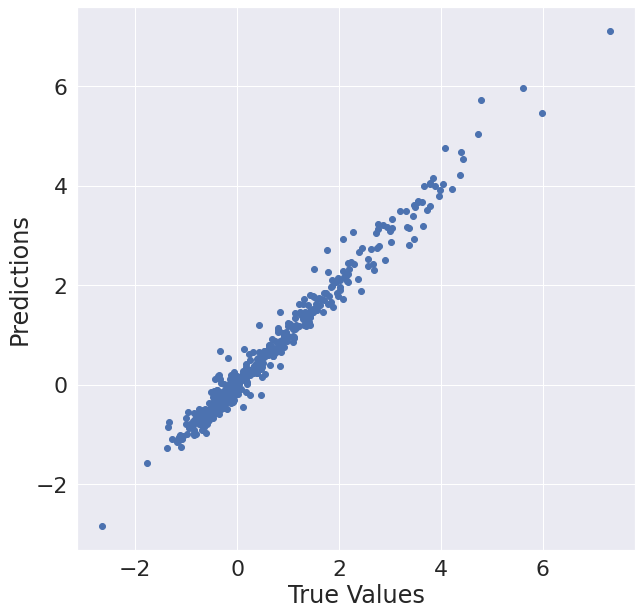

RMSE Full      : 23.64
R2 Full        :  0.98


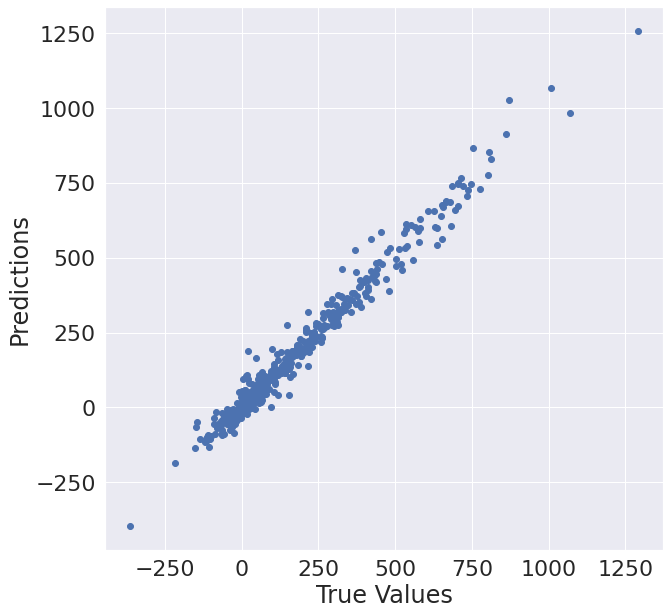

In [14]:
#denomrlize the results
plt.clf()
plt.scatter(results['y_full'], \
            results['y_pred_full'])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
y_pred_full = scalery.inverse_transform(results['y_pred_full'])
y_full = scalery.inverse_transform(results['y_full'])
rmse_full = mean_squared_error(y_full, y_pred_full, squared=False)
r2_full = r2_score(y_full, y_pred_full)
print("RMSE Full      : %5.2f"%rmse_full)
print("R2 Full        : %5.2f"%r2_full)

# plot the results
plt.clf()
plt.scatter(y_full, y_pred_full)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [15]:
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE , R2")
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    
    X_s = scalerx.transform(X)
    Y_s = scalery.transform(Y.reshape(-1, 1))
    y_pred = scalery.inverse_transform(results['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred = y_pred
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)

    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%r2)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE , R2
 118 ,                          BARRIER_HEIGHTS  ,    6.410  ,   21.488  ,   14.606  ,    0.519
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,   14.651  ,   19.653  ,    0.377
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,   17.811  ,   17.001  ,   -1.883
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    2.686  ,    2.941  ,    0.663
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    5.711  ,   13.513  ,    0.657
  13 ,                     BARRIER_HEIGHTS_PX13  ,   11.730  ,   49.956  ,   21.040  ,   -1.207
  18 ,                   BARRIER_HEIGHTS_WCPT18  ,    8.999  ,   24.302  ,   13.795  ,    0.644
 147 ,              INTRAMOLECULAR_INTERACTIONS  ,    1.137  ,    5.268  ,    6.124  ,   -0.021
  15 ,        INTRAMOLECULAR_INTERACTIONS_ACONF  ,    0.090  ,    1.250  ,    1.370  ,   -0.158
  17 ,        INTRAMO

RMSE  BARRIER_HEIGHTS  :  14.61
R2    BARRIER_HEIGHTS  :   0.52


<Figure size 720x720 with 0 Axes>

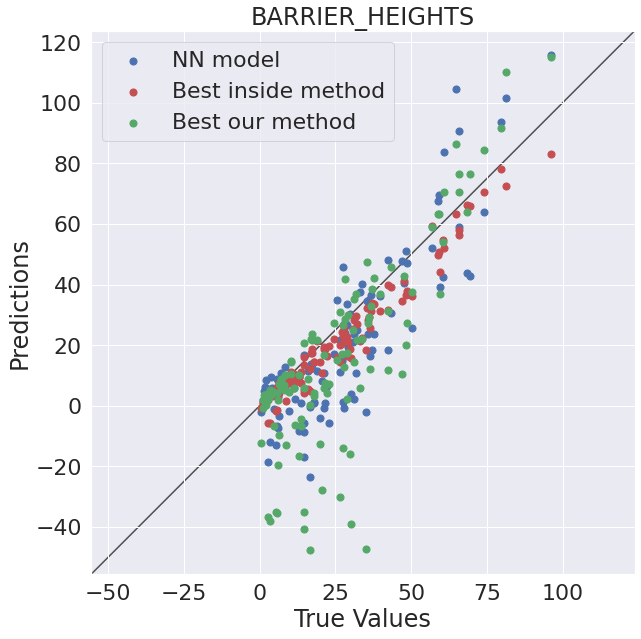

RMSE  BARRIER_HEIGHTS_BHDIV10  :  19.65
R2    BARRIER_HEIGHTS_BHDIV10  :   0.38


<Figure size 720x720 with 0 Axes>

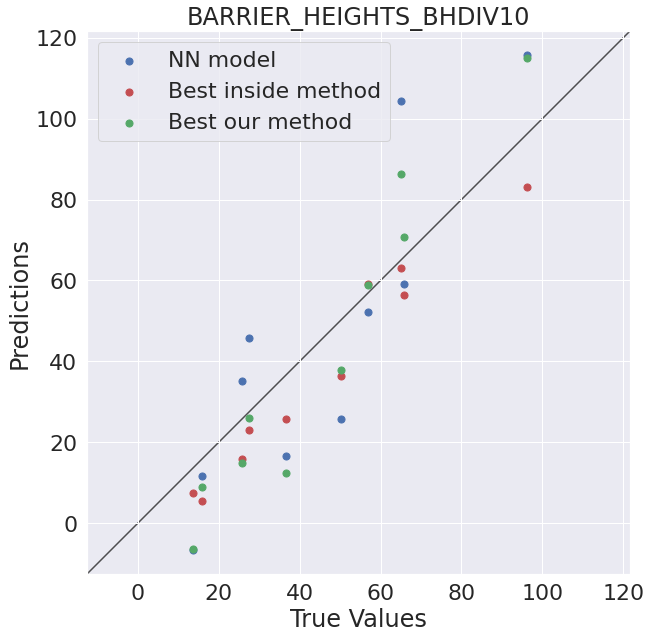

RMSE  BARRIER_HEIGHTS_BHPERI  :  17.00
R2    BARRIER_HEIGHTS_BHPERI  :  -1.88


<Figure size 720x720 with 0 Axes>

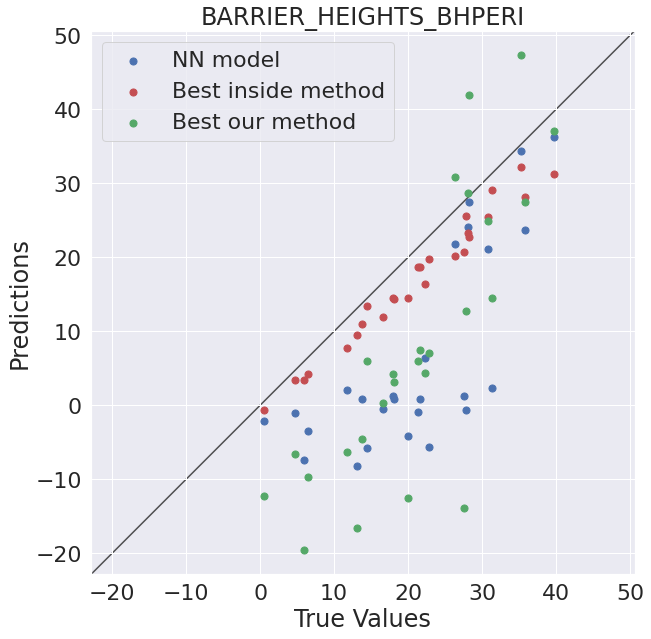

RMSE  BARRIER_HEIGHTS_BHROT27  :   2.94
R2    BARRIER_HEIGHTS_BHROT27  :   0.66


<Figure size 720x720 with 0 Axes>

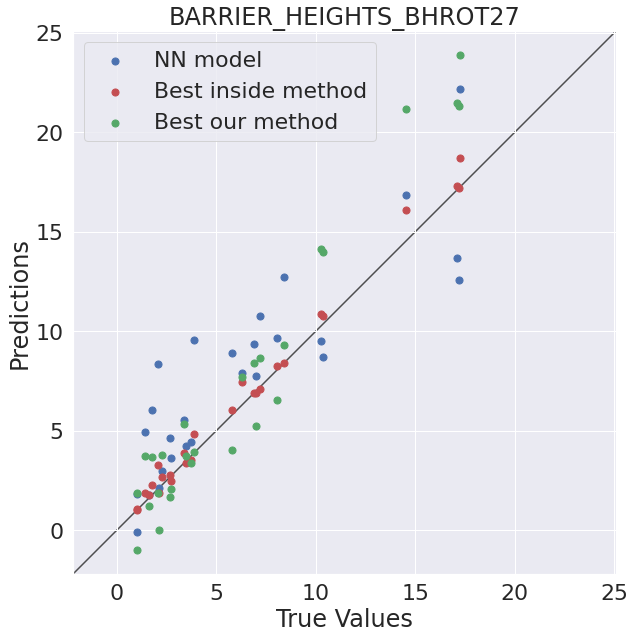

RMSE  BARRIER_HEIGHTS_INV24  :  13.51
R2    BARRIER_HEIGHTS_INV24  :   0.66


<Figure size 720x720 with 0 Axes>

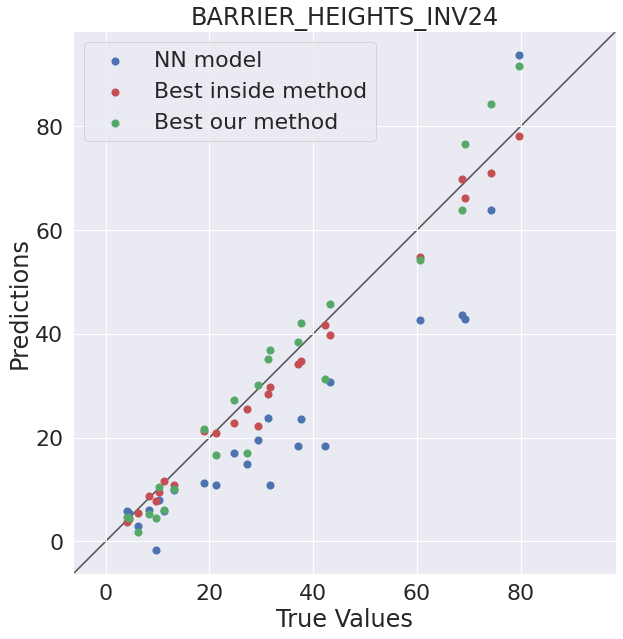

RMSE  BARRIER_HEIGHTS_PX13  :  21.04
R2    BARRIER_HEIGHTS_PX13  :  -1.21


<Figure size 720x720 with 0 Axes>

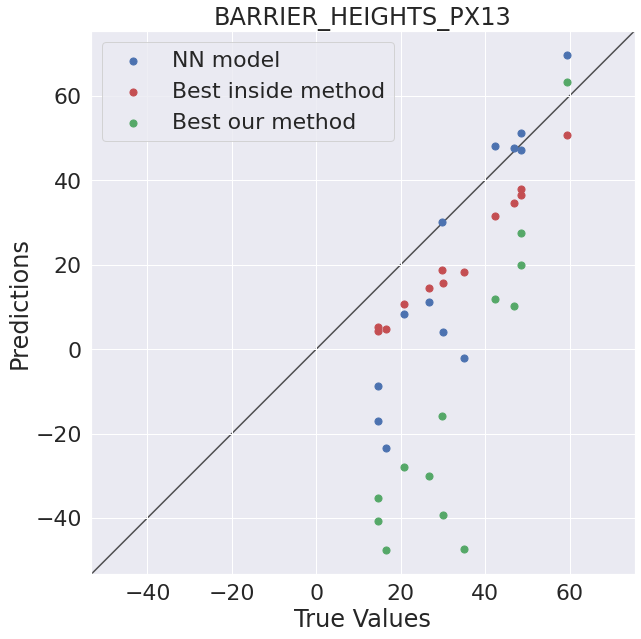

RMSE  BARRIER_HEIGHTS_WCPT18  :  13.80
R2    BARRIER_HEIGHTS_WCPT18  :   0.64


<Figure size 720x720 with 0 Axes>

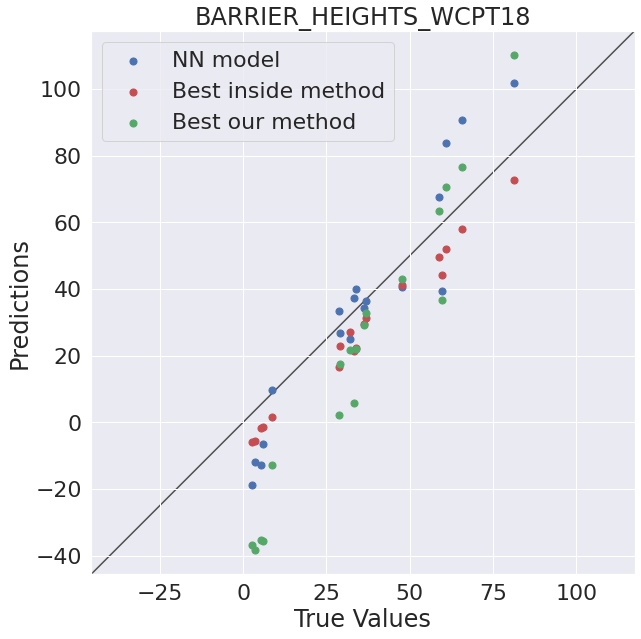

RMSE  INTRAMOLECULAR_INTERACTIONS  :   6.12
R2    INTRAMOLECULAR_INTERACTIONS  :  -0.02


<Figure size 720x720 with 0 Axes>

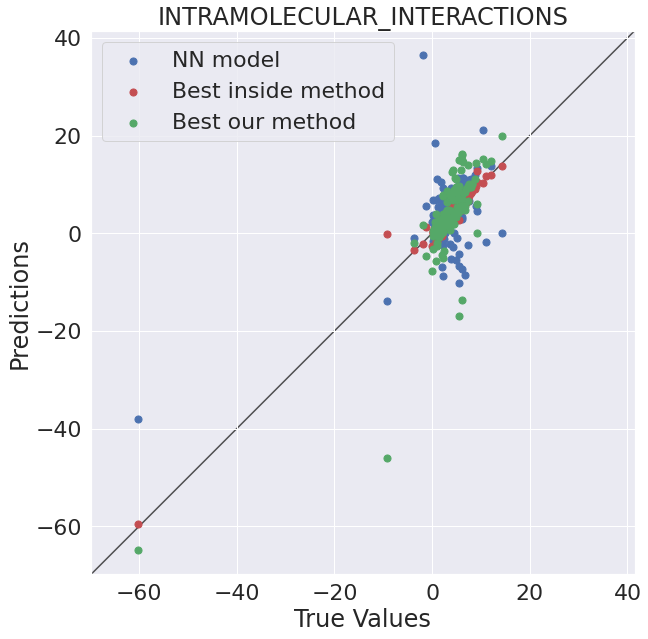

RMSE  INTRAMOLECULAR_INTERACTIONS_ACONF  :   1.37
R2    INTRAMOLECULAR_INTERACTIONS_ACONF  :  -0.16


<Figure size 720x720 with 0 Axes>

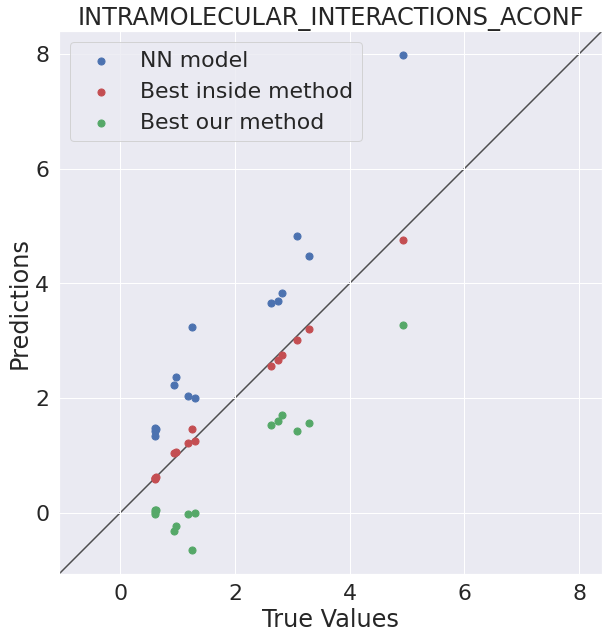

RMSE  INTRAMOLECULAR_INTERACTIONS_ICONF  :   4.08
R2    INTRAMOLECULAR_INTERACTIONS_ICONF  :  -0.67


<Figure size 720x720 with 0 Axes>

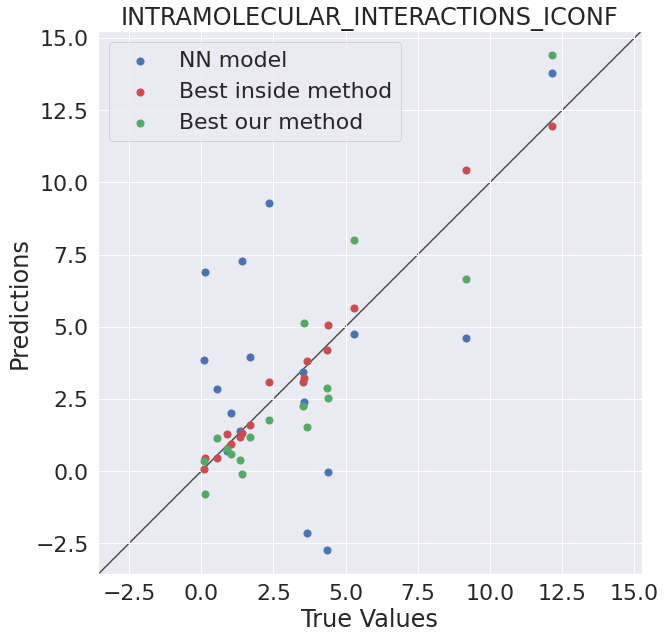

RMSE  INTRAMOLECULAR_INTERACTIONS_IDISP  :  18.51
R2    INTRAMOLECULAR_INTERACTIONS_IDISP  :   0.33


<Figure size 720x720 with 0 Axes>

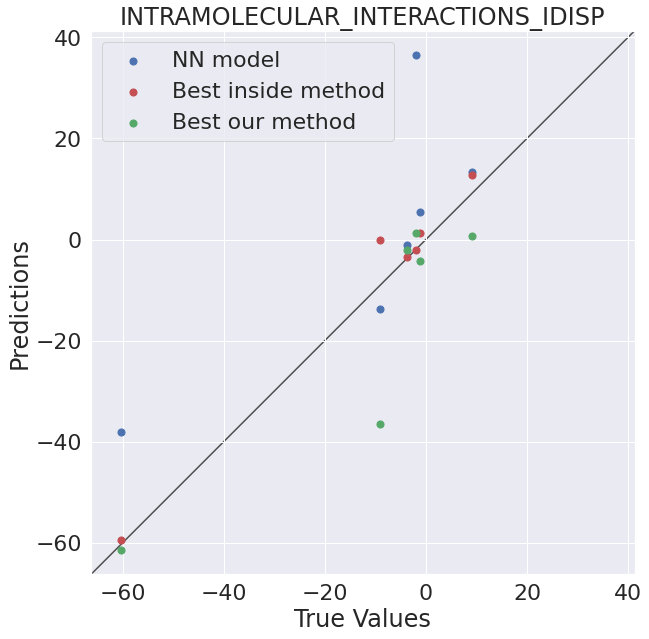

RMSE  INTRAMOLECULAR_INTERACTIONS_MCONF  :   2.98
R2    INTRAMOLECULAR_INTERACTIONS_MCONF  :  -1.25


<Figure size 720x720 with 0 Axes>

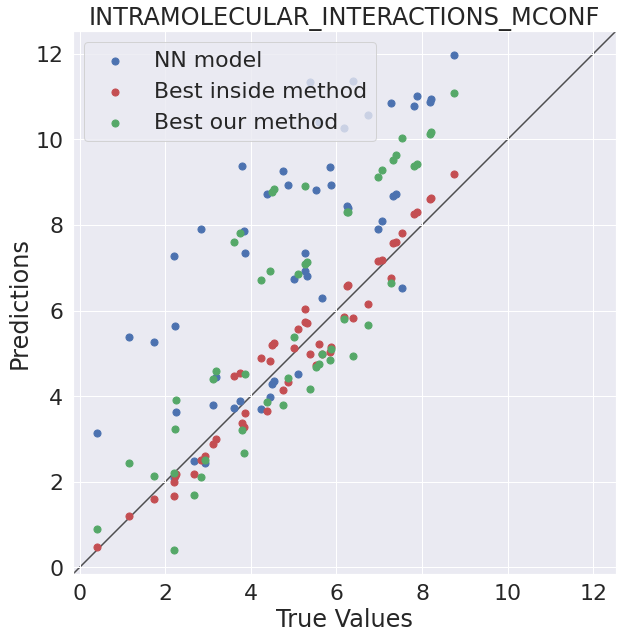

RMSE  INTRAMOLECULAR_INTERACTIONS_PCONF21  :   4.20
R2    INTRAMOLECULAR_INTERACTIONS_PCONF21  : -30.03


<Figure size 720x720 with 0 Axes>

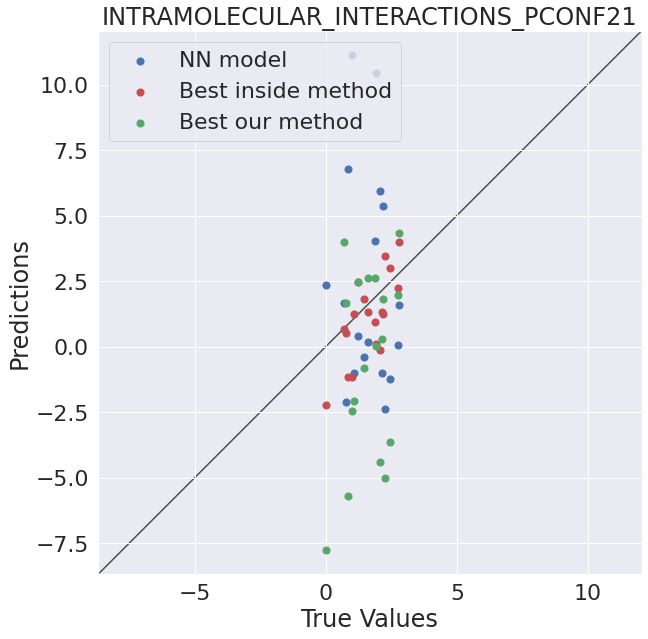

RMSE  INTRAMOLECULAR_INTERACTIONS_SCONF  :   5.25
R2    INTRAMOLECULAR_INTERACTIONS_SCONF  :  -6.92


<Figure size 720x720 with 0 Axes>

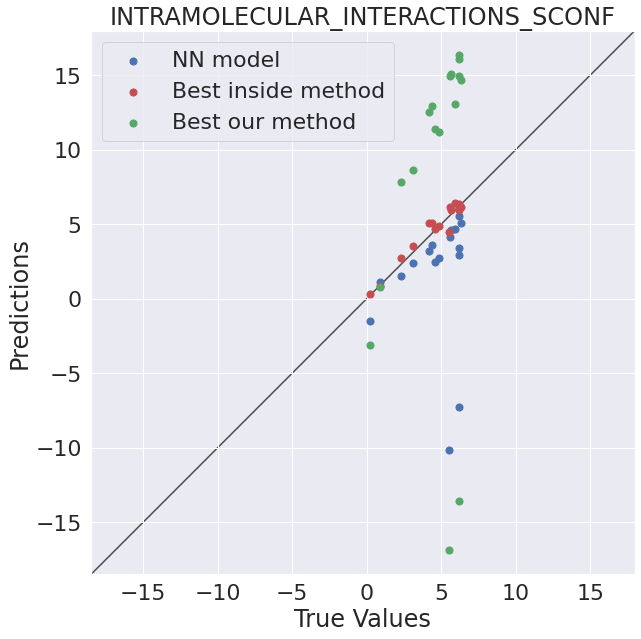

RMSE  INTRAMOLECULAR_INTERACTIONS_UPU23  :   9.10
R2    INTRAMOLECULAR_INTERACTIONS_UPU23  :  -7.54


<Figure size 720x720 with 0 Axes>

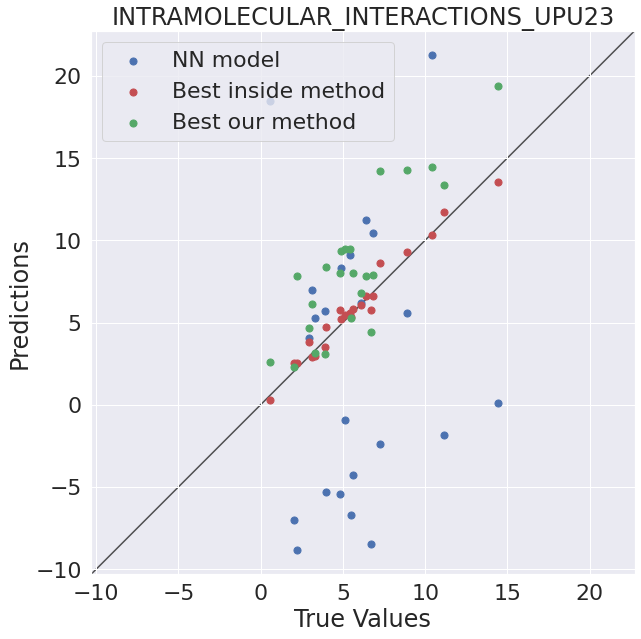

RMSE  SMALL_MOLECULES  :  25.52
R2    SMALL_MOLECULES  :   0.98


<Figure size 720x720 with 0 Axes>

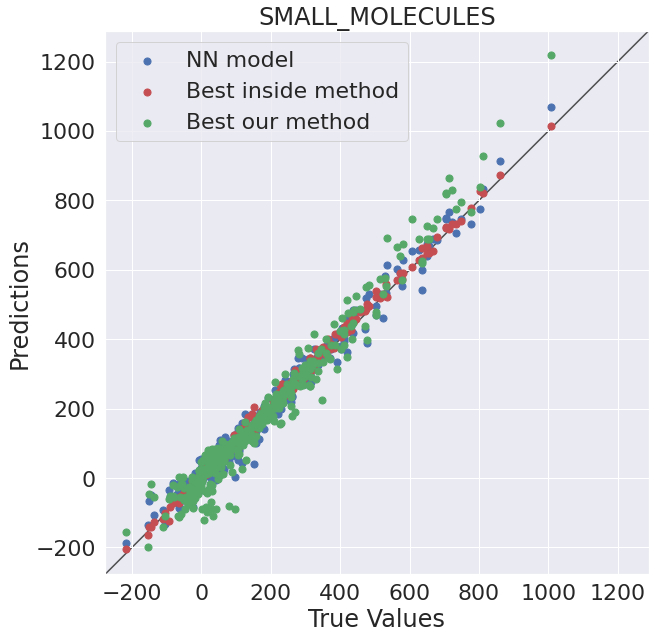

RMSE  SMALL_MOLECULES_AL2X6  :   9.22
R2    SMALL_MOLECULES_AL2X6  :  -0.12


<Figure size 720x720 with 0 Axes>

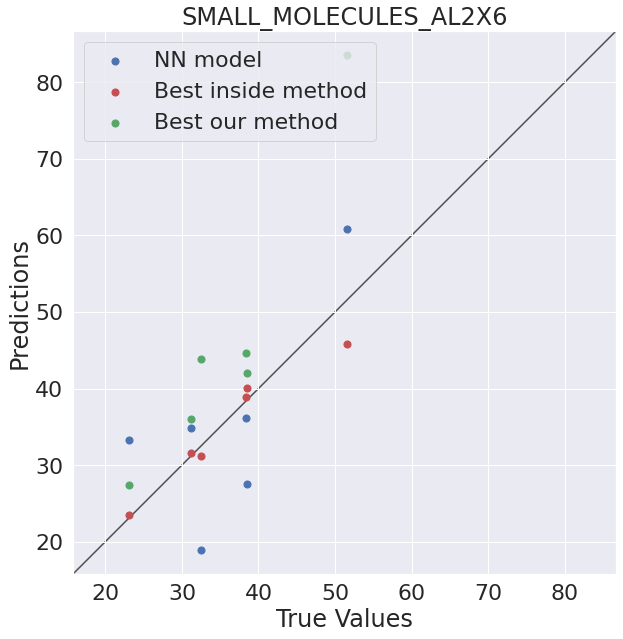

RMSE  SMALL_MOLECULES_ALK8  :  12.11
R2    SMALL_MOLECULES_ALK8  :   0.85


<Figure size 720x720 with 0 Axes>

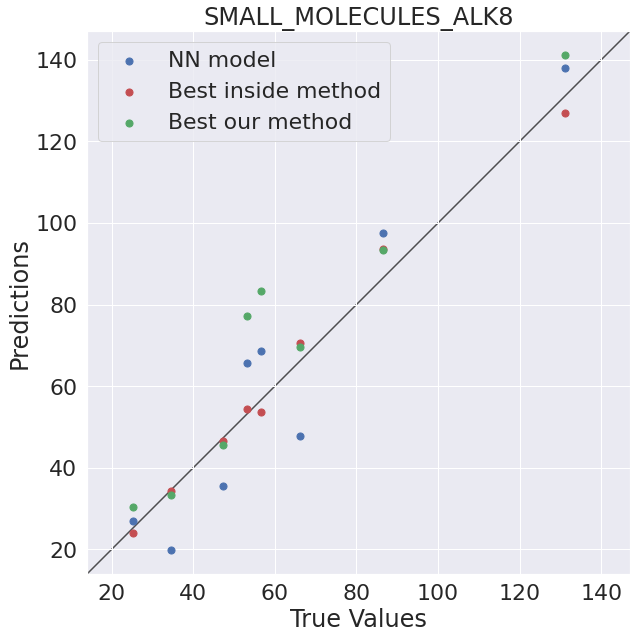

RMSE  SMALL_MOLECULES_ALKBDE10  :  45.94
R2    SMALL_MOLECULES_ALKBDE10  :  -1.11


<Figure size 720x720 with 0 Axes>

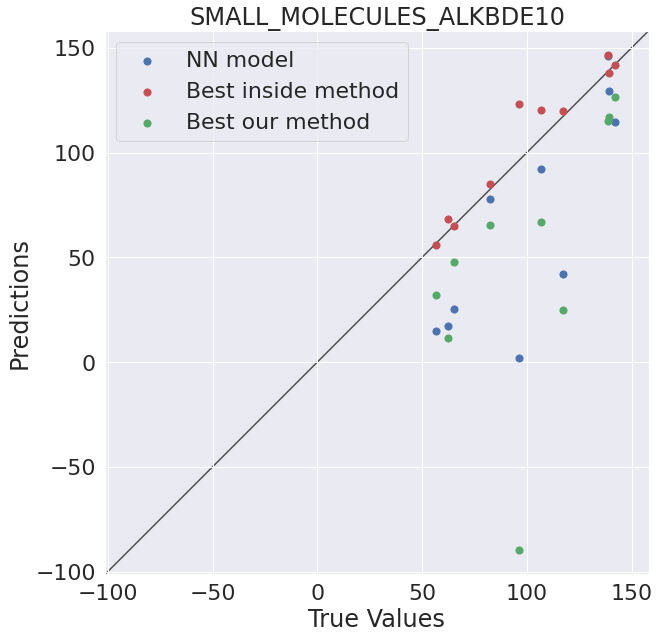

RMSE  SMALL_MOLECULES_DC13  :  43.40
R2    SMALL_MOLECULES_DC13  :   0.61


<Figure size 720x720 with 0 Axes>

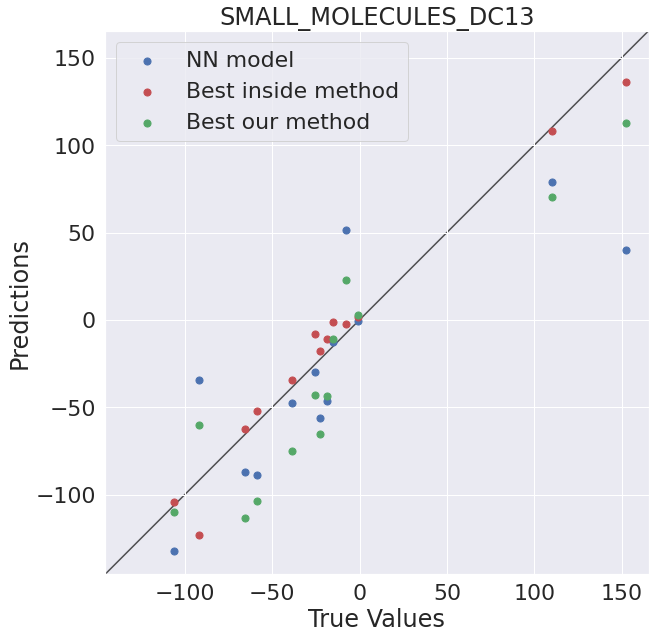

RMSE  SMALL_MOLECULES_DIPCS10  :  44.54
R2    SMALL_MOLECULES_DIPCS10  :   0.69


<Figure size 720x720 with 0 Axes>

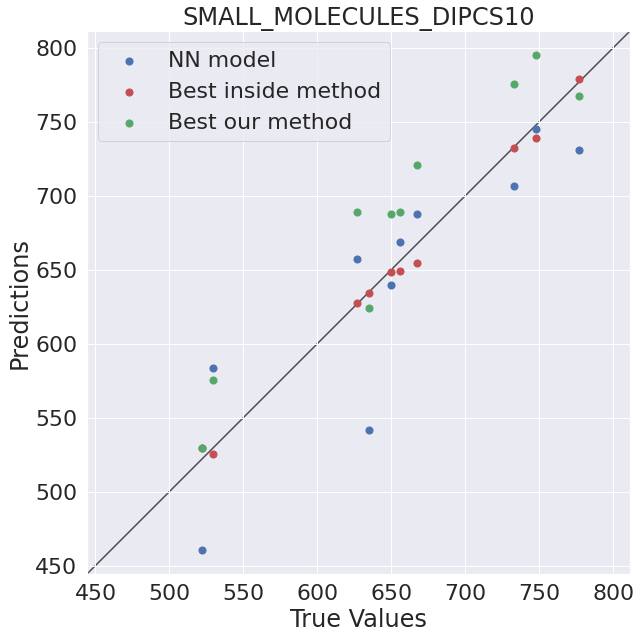

RMSE  SMALL_MOLECULES_FH51  :  25.09
R2    SMALL_MOLECULES_FH51  :   0.43


<Figure size 720x720 with 0 Axes>

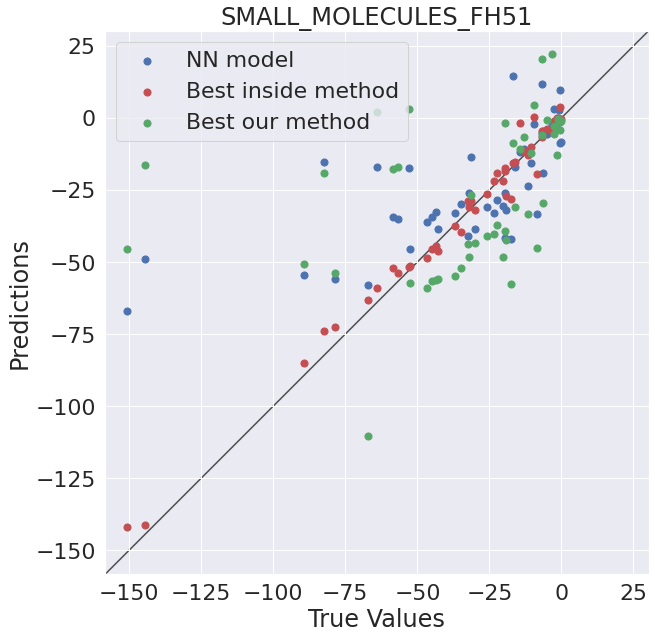

RMSE  SMALL_MOLECULES_G21EA  :  23.29
R2    SMALL_MOLECULES_G21EA  :  -0.00


<Figure size 720x720 with 0 Axes>

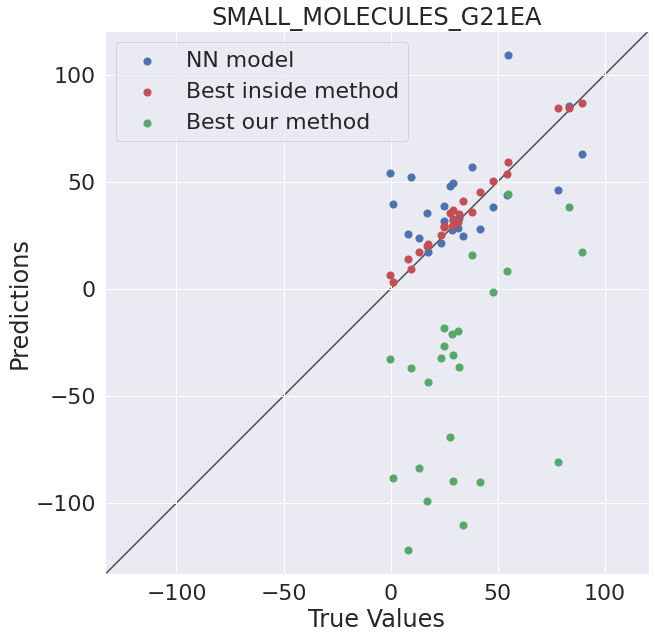

RMSE  SMALL_MOLECULES_G21IP  :  20.12
R2    SMALL_MOLECULES_G21IP  :   0.90


<Figure size 720x720 with 0 Axes>

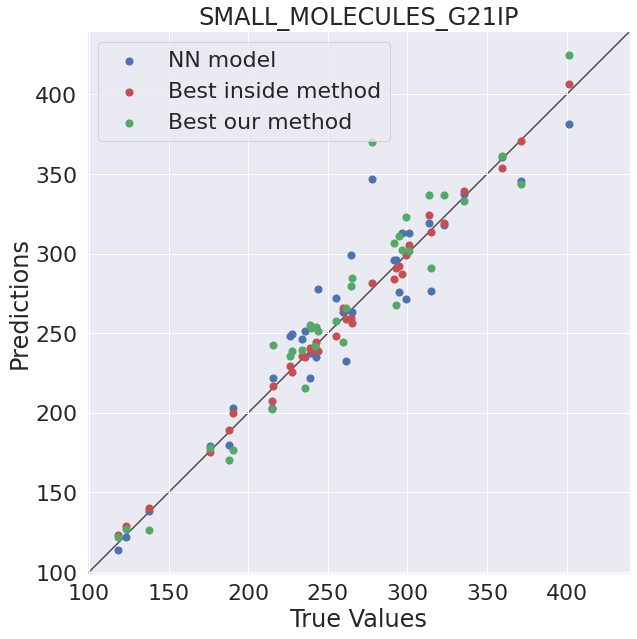

RMSE  SMALL_MOLECULES_G2RC  :  23.11
R2    SMALL_MOLECULES_G2RC  :   0.80


<Figure size 720x720 with 0 Axes>

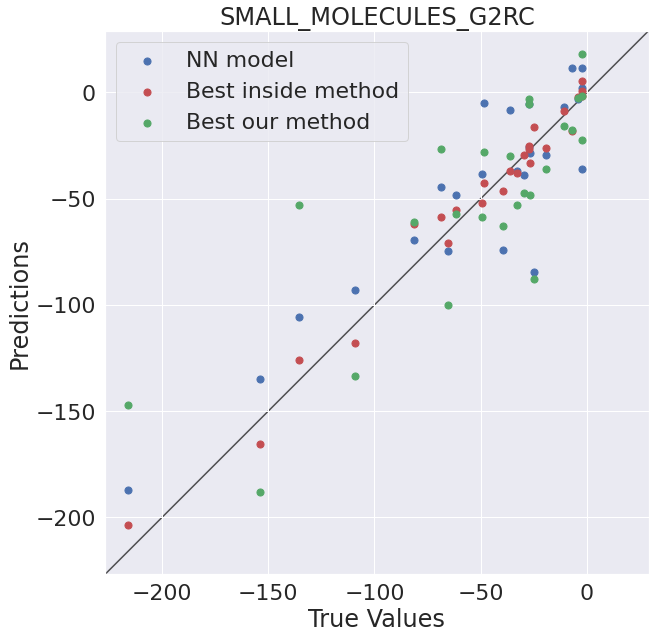

RMSE  SMALL_MOLECULES_NBPRC  :  12.69
R2    SMALL_MOLECULES_NBPRC  :   0.82


<Figure size 720x720 with 0 Axes>

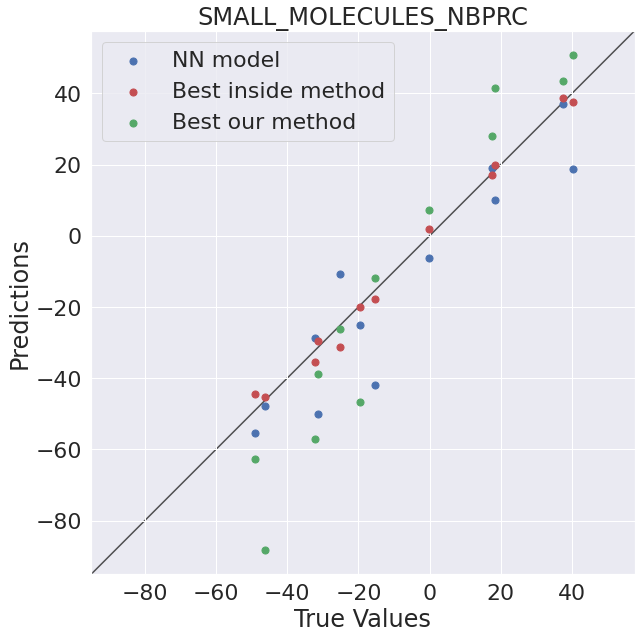

RMSE  SMALL_MOLECULES_PA26  :  24.04
R2    SMALL_MOLECULES_PA26  :   0.45


<Figure size 720x720 with 0 Axes>

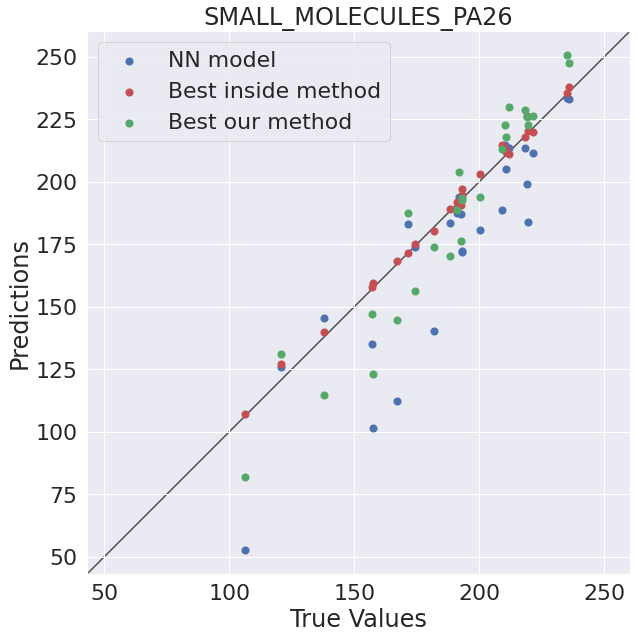

RMSE  SMALL_MOLECULES_RC21  :  20.93
R2    SMALL_MOLECULES_RC21  :   0.38


<Figure size 720x720 with 0 Axes>

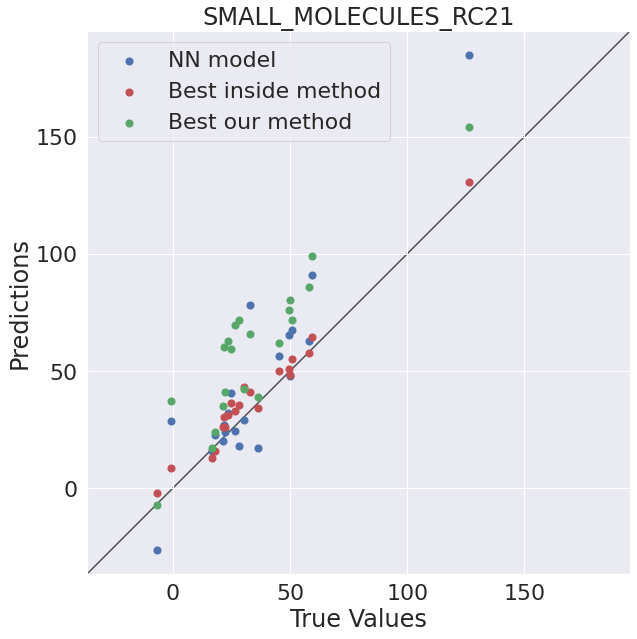

RMSE  SMALL_MOLECULES_SIE4x4  :  12.65
R2    SMALL_MOLECULES_SIE4x4  :   0.49


<Figure size 720x720 with 0 Axes>

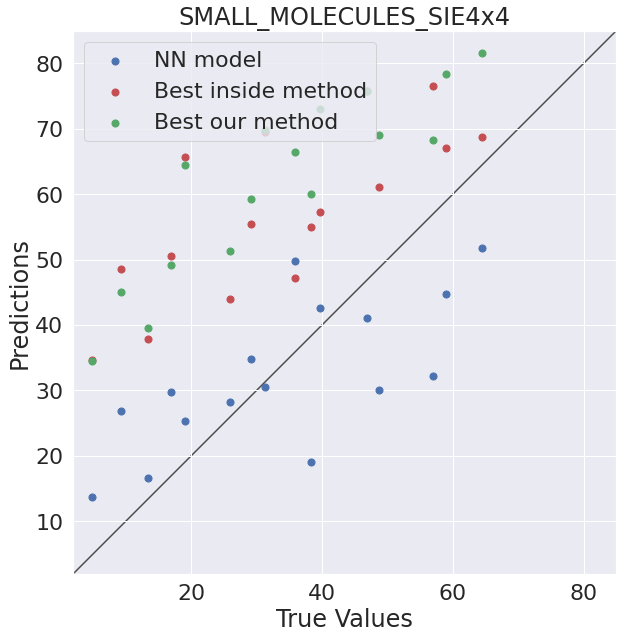

RMSE  SMALL_MOLECULES_TAUT15  :   9.64
R2    SMALL_MOLECULES_TAUT15  :  -4.82


<Figure size 720x720 with 0 Axes>

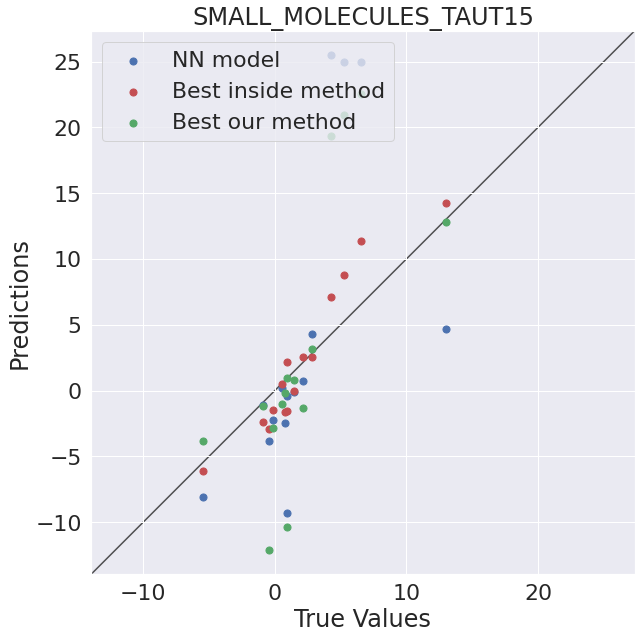

RMSE  SMALL_MOLECULES_W4-11  :  27.16
R2    SMALL_MOLECULES_W4-11  :   0.98


<Figure size 720x720 with 0 Axes>

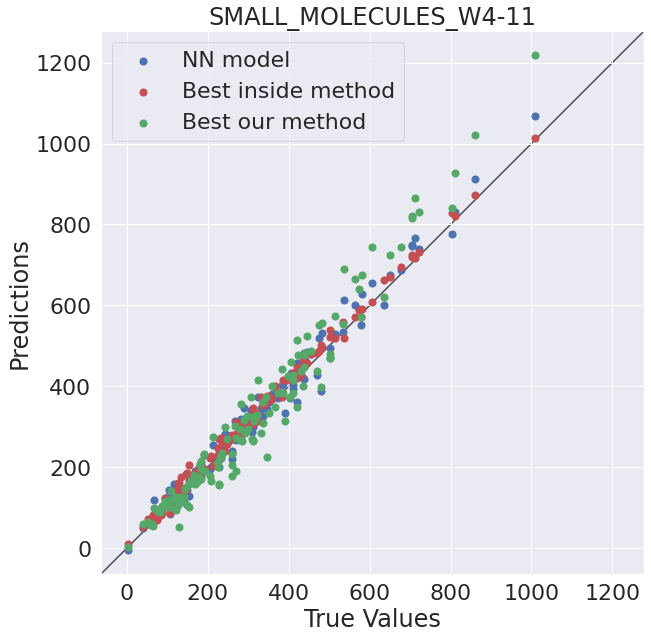

RMSE  SMALL_MOLECULES_YBDE18  :  20.03
R2    SMALL_MOLECULES_YBDE18  :  -0.02


<Figure size 720x720 with 0 Axes>

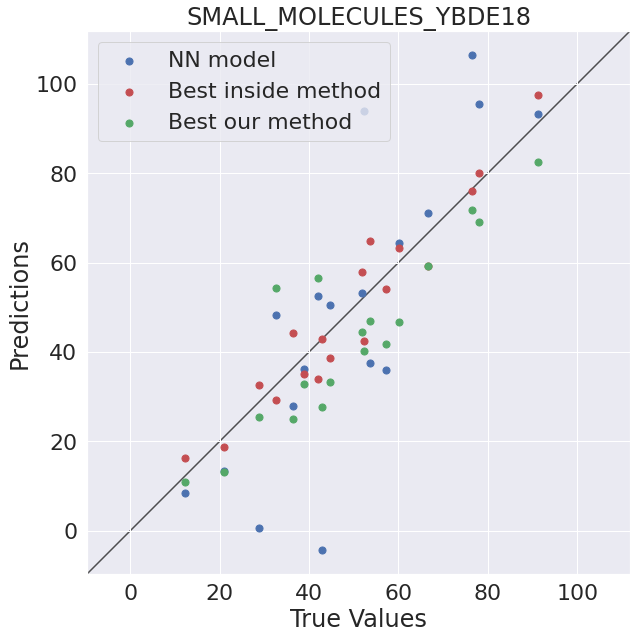

RMSE  INTERMOLECULAR_INTERACTIONS  :  15.47
R2    INTERMOLECULAR_INTERACTIONS  :   0.87


<Figure size 720x720 with 0 Axes>

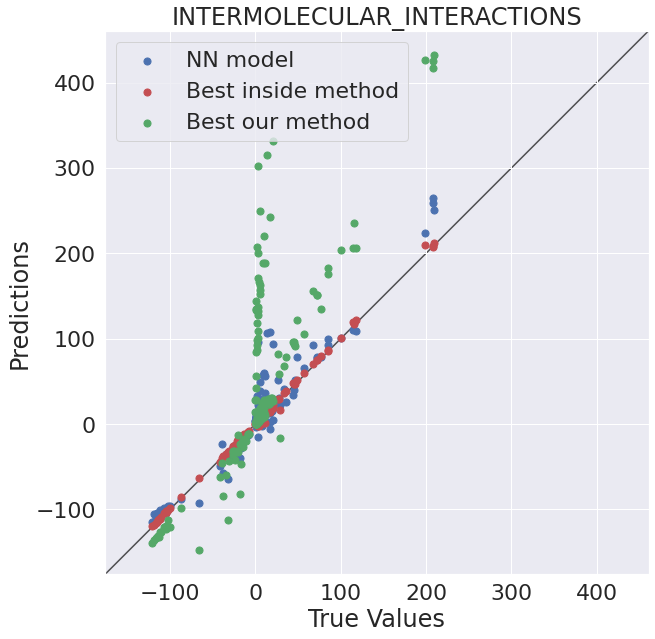

RMSE  INTERMOLECULAR_INTERACTIONS_ADIM6  :   8.64
R2    INTERMOLECULAR_INTERACTIONS_ADIM6  : -34.27


<Figure size 720x720 with 0 Axes>

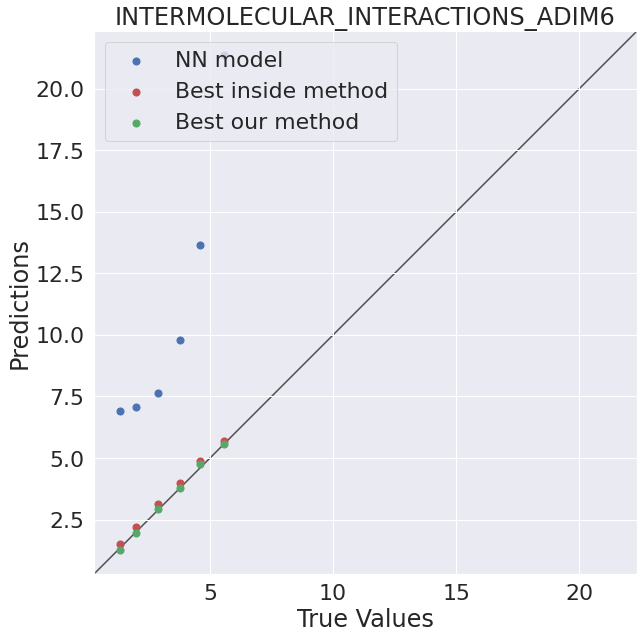

RMSE  INTERMOLECULAR_INTERACTIONS_AHB21  :  12.46
R2    INTERMOLECULAR_INTERACTIONS_AHB21  :   0.13


<Figure size 720x720 with 0 Axes>

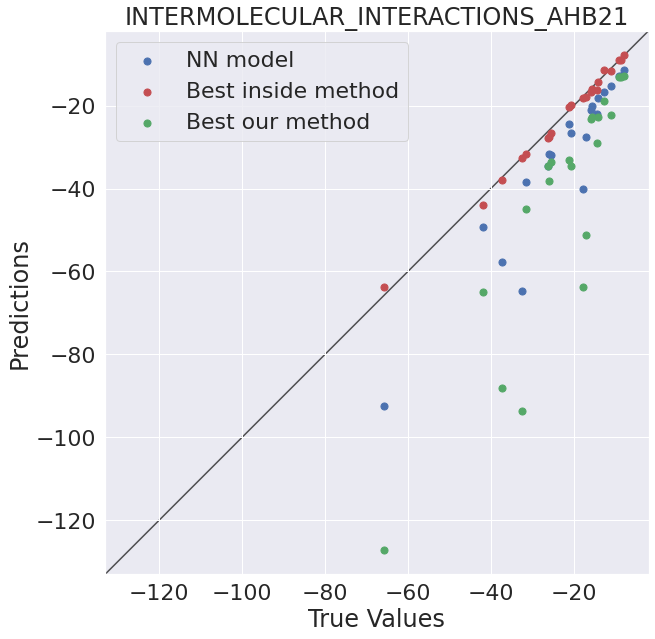

RMSE  INTERMOLECULAR_INTERACTIONS_CARBHB12  :   2.58
R2    INTERMOLECULAR_INTERACTIONS_CARBHB12  :   0.63


<Figure size 720x720 with 0 Axes>

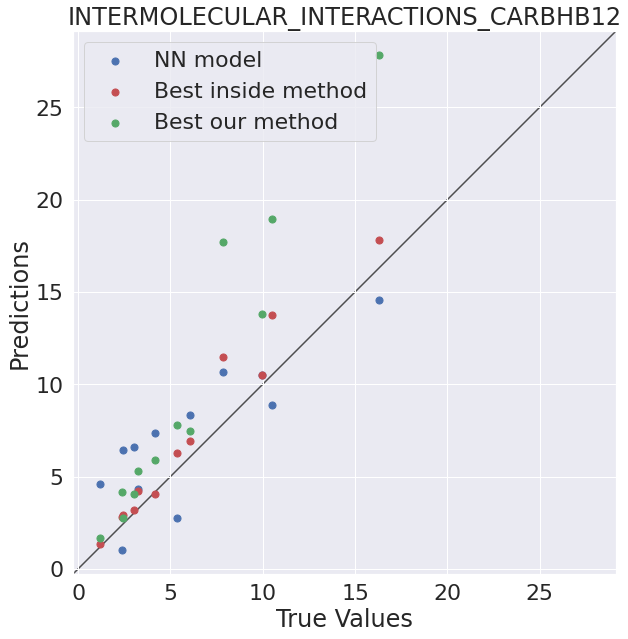

RMSE  INTERMOLECULAR_INTERACTIONS_CHB6  :   6.95
R2    INTERMOLECULAR_INTERACTIONS_CHB6  :   0.17


<Figure size 720x720 with 0 Axes>

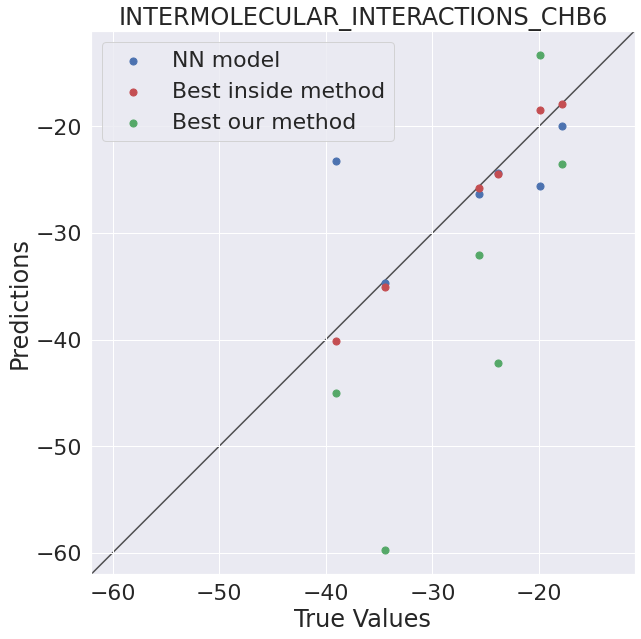

RMSE  INTERMOLECULAR_INTERACTIONS_HAL59  :  27.55
R2    INTERMOLECULAR_INTERACTIONS_HAL59  : -41.73


<Figure size 720x720 with 0 Axes>

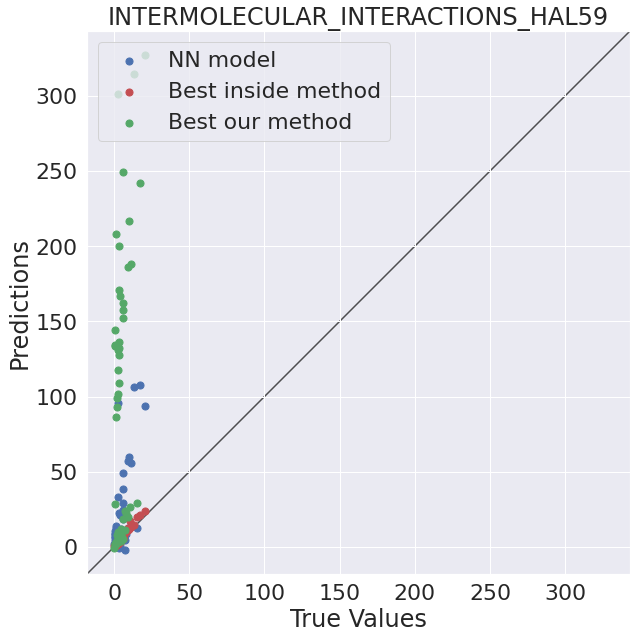

RMSE  INTERMOLECULAR_INTERACTIONS_IL16  :   7.48
R2    INTERMOLECULAR_INTERACTIONS_IL16  :   0.14


<Figure size 720x720 with 0 Axes>

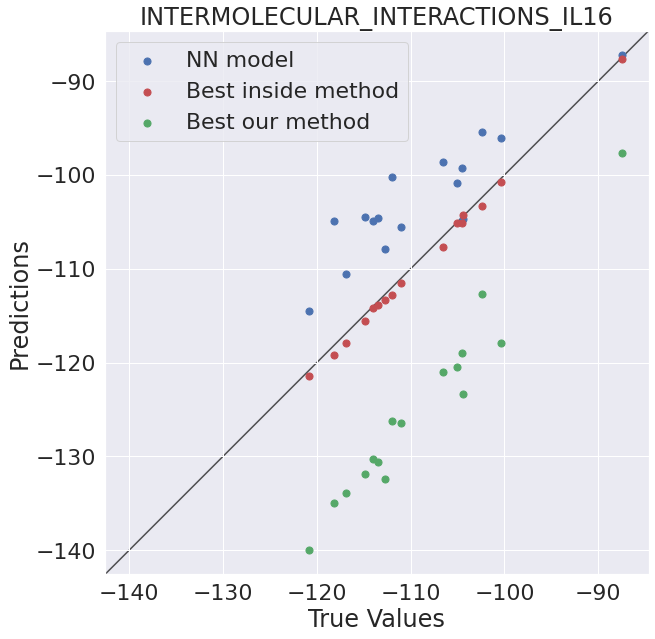

RMSE  INTERMOLECULAR_INTERACTIONS_PNICO23  :   4.98
R2    INTERMOLECULAR_INTERACTIONS_PNICO23  :  -2.57


<Figure size 720x720 with 0 Axes>

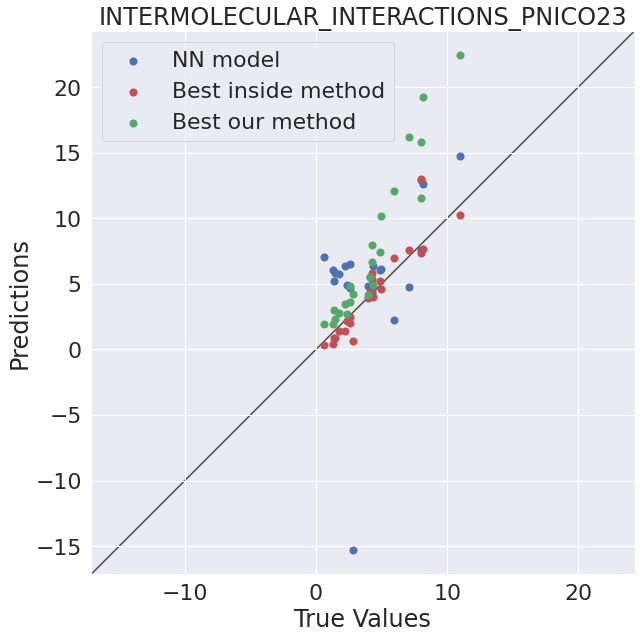

RMSE  INTERMOLECULAR_INTERACTIONS_RG18  :   4.38
R2    INTERMOLECULAR_INTERACTIONS_RG18  : -118.09


<Figure size 720x720 with 0 Axes>

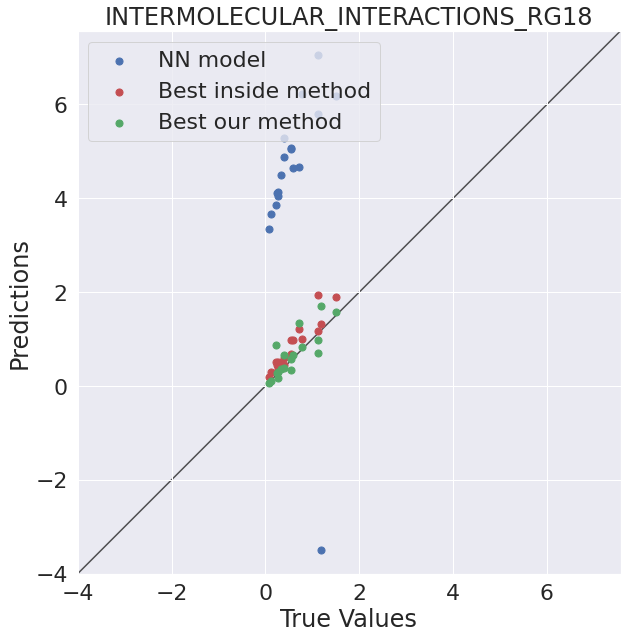

RMSE  INTERMOLECULAR_INTERACTIONS_S22  :   9.75
R2    INTERMOLECULAR_INTERACTIONS_S22  :  -1.39


<Figure size 720x720 with 0 Axes>

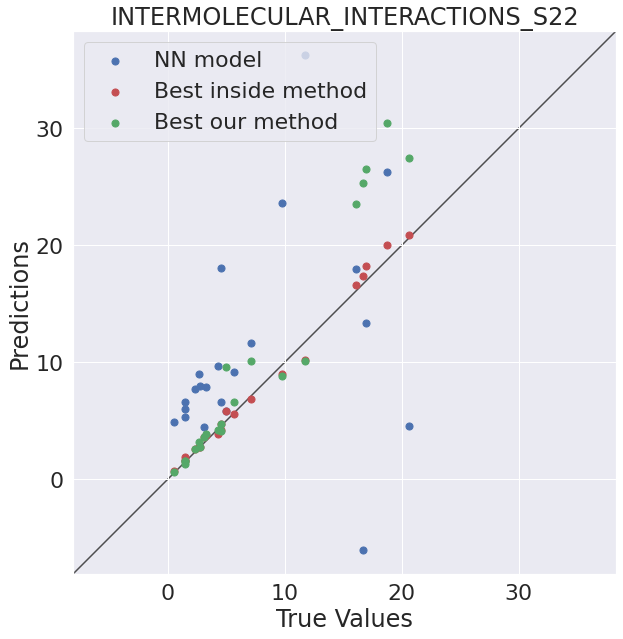

RMSE  INTERMOLECULAR_INTERACTIONS_S66  :   5.50
R2    INTERMOLECULAR_INTERACTIONS_S66  :  -0.79


<Figure size 720x720 with 0 Axes>

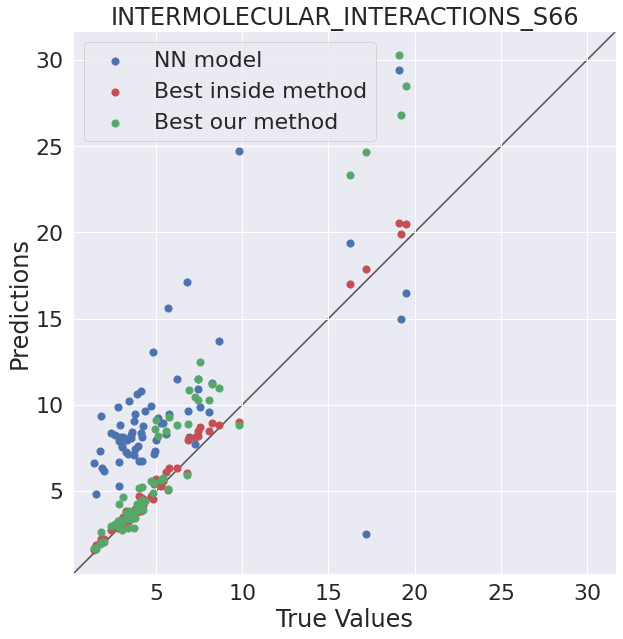

RMSE  INTERMOLECULAR_INTERACTIONS_WATER27  :  20.44
R2    INTERMOLECULAR_INTERACTIONS_WATER27  :   0.88


<Figure size 720x720 with 0 Axes>

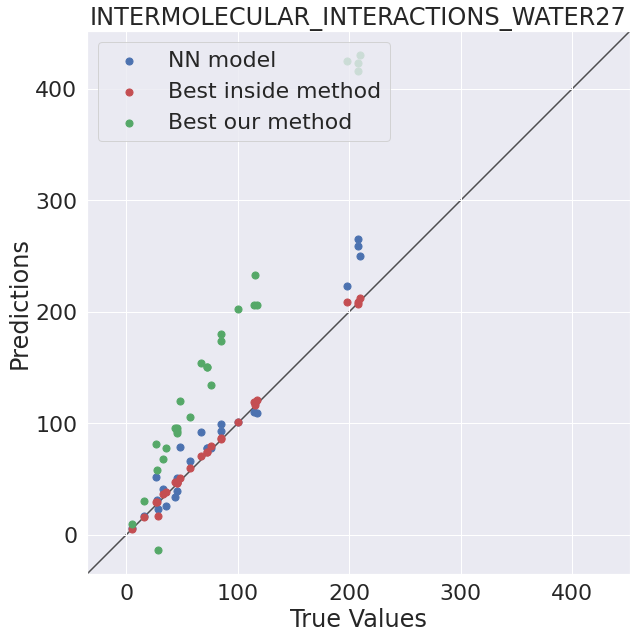

RMSE  LARGE_SYSTEMS  :  35.80
R2    LARGE_SYSTEMS  :   0.97


<Figure size 720x720 with 0 Axes>

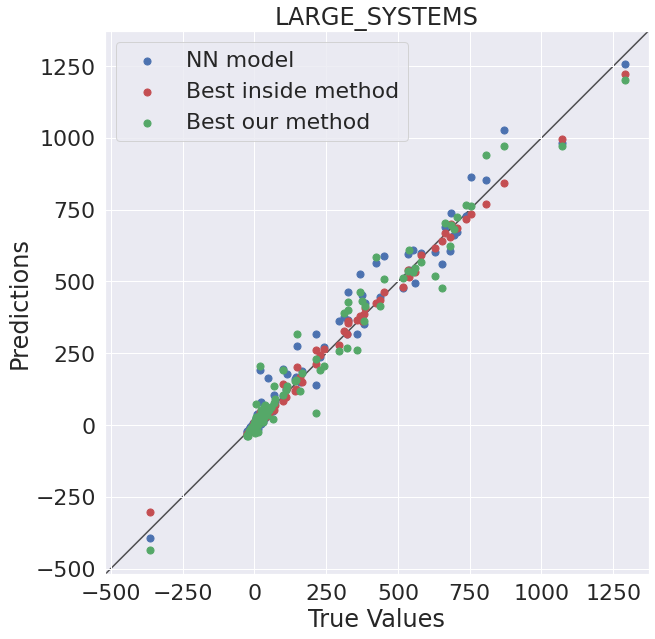

RMSE  LARGE_SYSTEMS_BSR36  :   9.19
R2    LARGE_SYSTEMS_BSR36  :   0.27


<Figure size 720x720 with 0 Axes>

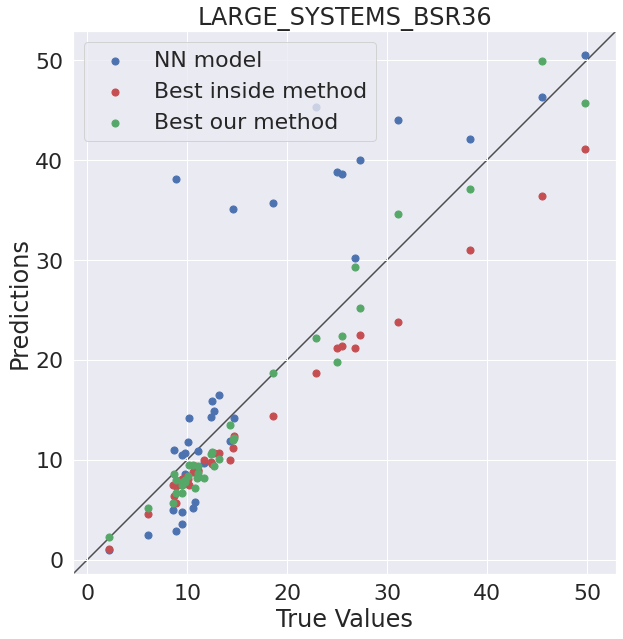

RMSE  LARGE_SYSTEMS_C60ISO  :  14.25
R2    LARGE_SYSTEMS_C60ISO  :   0.89


<Figure size 720x720 with 0 Axes>

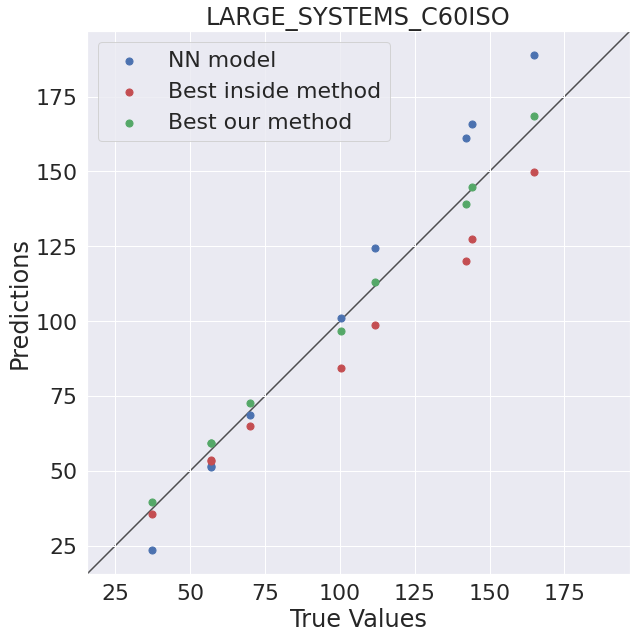

RMSE  LARGE_SYSTEMS_CDIE20  :   4.09
R2    LARGE_SYSTEMS_CDIE20  :  -0.25


<Figure size 720x720 with 0 Axes>

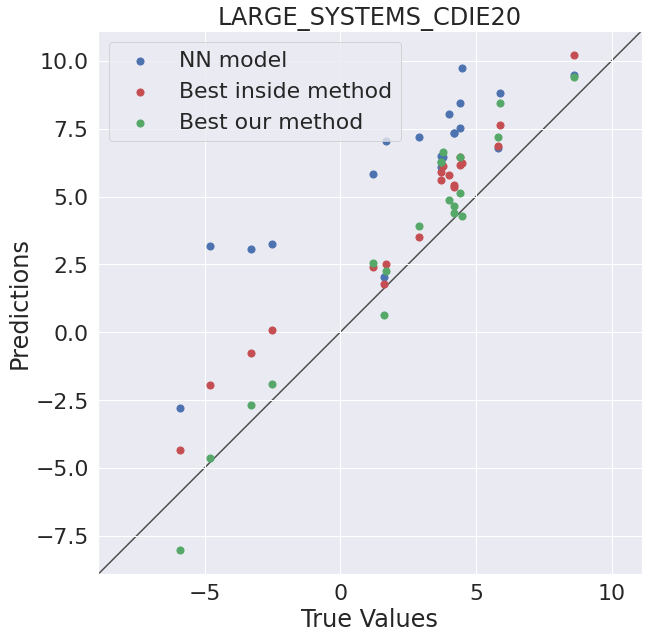

RMSE  LARGE_SYSTEMS_ISO34  :   8.43
R2    LARGE_SYSTEMS_ISO34  :   0.64


<Figure size 720x720 with 0 Axes>

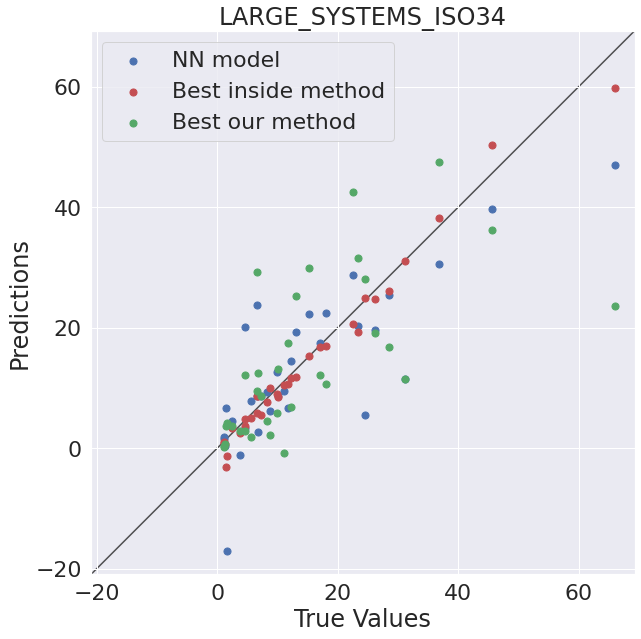

RMSE  LARGE_SYSTEMS_ISOL24  :  17.60
R2    LARGE_SYSTEMS_ISOL24  :   0.06


<Figure size 720x720 with 0 Axes>

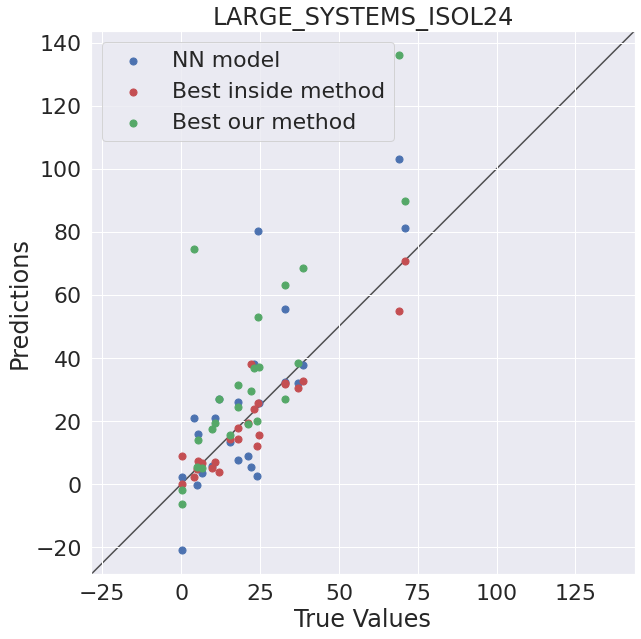

RMSE  LARGE_SYSTEMS_MB16-43  :  80.21
R2    LARGE_SYSTEMS_MB16-43  :   0.93


<Figure size 720x720 with 0 Axes>

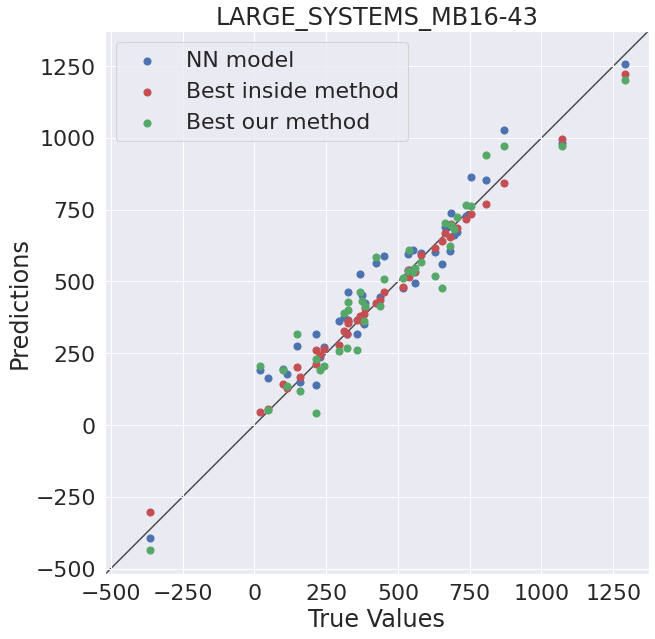

RMSE  LARGE_SYSTEMS_PArel  :   8.21
R2    LARGE_SYSTEMS_PArel  :  -2.87


<Figure size 720x720 with 0 Axes>

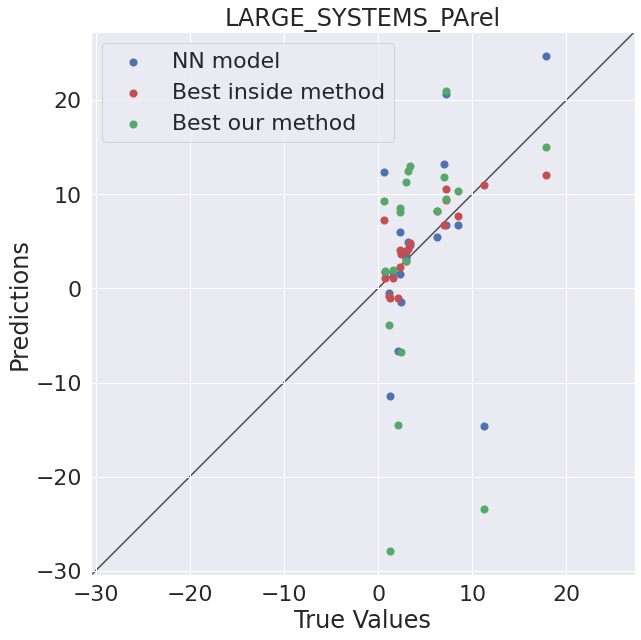

RMSE  LARGE_SYSTEMS_RSE43  :   3.34
R2    LARGE_SYSTEMS_RSE43  :   0.79


<Figure size 720x720 with 0 Axes>

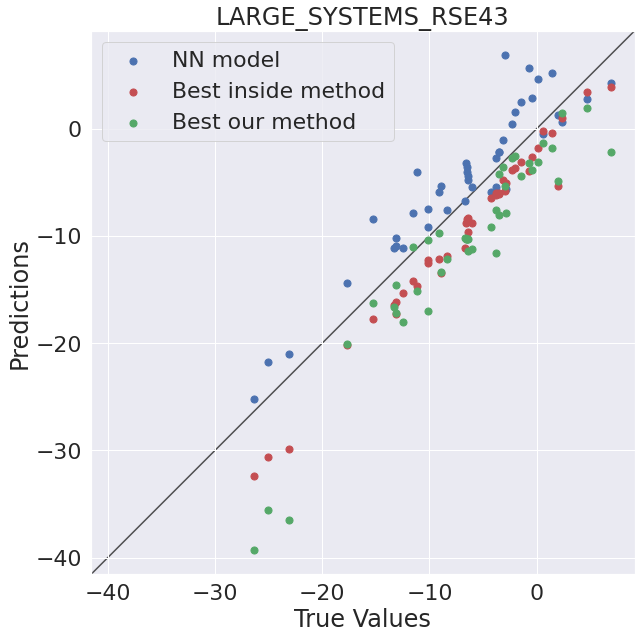

RMSE  Full  :  23.64
R2    Full  :   0.98


<Figure size 720x720 with 0 Axes>

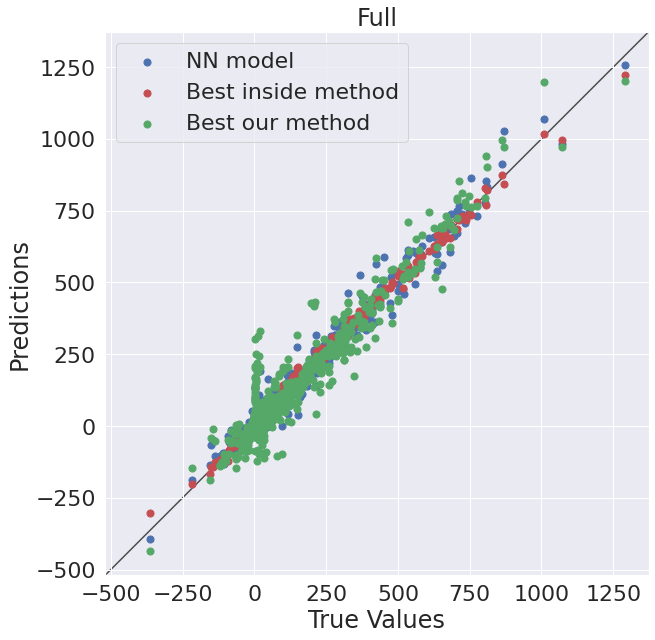

In [16]:
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    y_pred = models_results[setname].y_pred 
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)
    print("RMSE ", setname, " : %6.2f"%rmse)
    print("R2   ", setname, " : %6.2f"%r2)
    plt.clf()
    #plt.scatter(Y, y_pred)

    fig, ax = plt.subplots()
    #plt.scatter(Y, y_pred, c='b', s=30, label='NN model', \
    #            marker=".")
    #plt.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
    #            c='r', label='Best inside method',  \
    #                marker=".")
    #plt.scatter(Y, models_results[setname].y_pred_bestourmethod, \
    #            c='g', label='Best our method', \
    #                marker=".")
    ax.scatter(Y, y_pred, c='b', s=50, label='NN model')
    ax.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
                c='r', s=50, label='Best inside method')
    ax.scatter(Y, models_results[setname].y_pred_bestourmethod, \
               c='g', s=50, label='Best our method')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(loc="upper left")
    plt.title(setname)
    plt.show()